# LIBRERÍAS Y PREPARACIÓN DATASET

In [ ]:
# importar las librerías requeridas
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
from keras.layers import Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import os
import glob
#Importar librería de google drive para la carga de los archivos de datos requeridos.
from google.colab import drive

from statsmodels.graphics.tsaplots import plot_acf


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import math
from sklearn.metrics import mean_squared_error, r2_score

import plotly.graph_objs as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta, datetime


Definiciones

In [ ]:
entrenamiento='2024-02-05'
#validacion='2023-12-31'
fin_pruebas='2024-03-31'

lookback = 24 # Número de pasos hacia atrás
steps_ahead=168 # Número de pasos adelante
blackout=168
semanas_test=1
dias_to_pred=14
fecha_inicio_pred=entrenamiento
fecha_inicio_pred=datetime.strptime(fecha_inicio_pred, "%Y-%m-%d")- timedelta(days=dias_to_pred//2)
fecha_fin_pred=fecha_inicio_pred + timedelta(days=dias_to_pred-1)


In [ ]:
def metricas(y_test, y_pred):

  # Convertir los arrays 1D a 2D
  Y_test_2d = y_test.reshape(-1, 1)
  #Y_test_2d = y_test
  Y_pred_2d = y_pred.reshape(-1, 1)
  #Y_pred_2d = y_pred
  #porcentaje_desviacion = porcentaje_desviacion.reshape(-1, 1)

  r2 = r2_score(Y_test_2d, Y_pred_2d)
  mse = mean_squared_error(y_true=Y_test_2d, y_pred=Y_pred_2d, squared=True)
  rmse = mean_squared_error(y_true=Y_test_2d, y_pred=Y_pred_2d, squared=False)
  mae = mean_absolute_error(y_true=Y_test_2d, y_pred=Y_pred_2d)
  mape=mean_absolute_percentage_error(y_true=Y_test_2d, y_pred=Y_pred_2d)
  print(f"r2:{r2}")
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"MAPE: {mape}")

  # Calcular la diferencia absoluta entre los valores de Y_test y Y_pred
  diferencia_absoluta = np.abs(Y_test_2d - Y_pred_2d)

  # Calcular el porcentaje de desviación
  porcentaje_desviacion = (diferencia_absoluta / Y_test_2d) * 100



  print('shapes:', Y_test_2d.shape, Y_pred_2d.shape, porcentaje_desviacion.shape)

  # Crear el DataFrame
  results= pd.DataFrame({'y_test': Y_test_2d.flatten(),
                    'y_pred': Y_pred_2d.flatten(),
                    '%error': porcentaje_desviacion.flatten()})

  # Imprimir el DataFrame
  print(results.head())
  return results,rmse

In [ ]:
def inv_scaler(scaler, y1,y2):
  # Obtiene el mínimo y el rango para la columna seleccionada
  minimo_columna = scaler.data_min_[0]  # Suponiendo que la columna seleccionada es la primera
  rango_columna = scaler.data_range_[0]  # Suponiendo que la columna seleccionada es la primera
  rango_escala = scaler.feature_range
  # Transforma inversamente las columnas seleccionada

  y1=(y1 -rango_escala[0]) / (rango_escala[1]-rango_escala[0])
  y2=(y2 -rango_escala[0]) / (rango_escala[1]-rango_escala[0])
  y1_inv = y1 * rango_columna + minimo_columna
  y2_inv = y2 * rango_columna + minimo_columna

  return y1_inv, y2_inv

In [ ]:


def graficar_pred(results):
  # Create traces
  trace_real = go.Scatter(x=results.index, y=results['y_test'], mode='lines', name='Demanda Real', line=dict(color='red'))
  trace_pred = go.Scatter(x=results.index, y=results['y_pred'], mode='lines', name='Predicción demanda', line=dict(color='blue'))

  # Create layout
  layout = go.Layout(title='Predicción demanda horaria usando Redes neuronales',
                    xaxis=dict(title='Time'),
                    yaxis=dict(title='Demanda'))

  # Create figure
  fig = go.Figure(data=[trace_real, trace_pred], layout=layout)

  # Display interactive plot
  fig.show()

Importar el dataset

In [ ]:

drive.mount('/content/drive')

# Se crea un path específico para facilitar la lectura de los archivos posteriormente desde google drive
path = "/content/drive/MyDrive/seminario-master/Datasets_salida/"

dataset=pd.read_csv(path + 'dataset_final/dataset_demada_Antioquia.csv', sep=',')



#Normalizar datos negativos
dataset.loc[dataset['ALLSKY_SFC_SW_DWN_pond'] < 0, 'ALLSKY_SFC_SW_DWN_pond'] = 0
dataset.loc[dataset['ALLSKY_SFC_SW_DWN_BAJO CAUCA'] < 0, 'ALLSKY_SFC_SW_DWN_BAJO CAUCA'] = 0
dataset.loc[dataset['ALLSKY_SFC_SW_DWN_URABA'] < 0, 'ALLSKY_SFC_SW_DWN_URABA'] = 0

dataset['FECHA'] = pd.to_datetime(dataset['FECHA'])

# Establecemos la columna 'FECHA' como el índice del DataFrame
dataset.set_index('FECHA', inplace=True)

dataset=dataset['2021-01-04':fin_pruebas]

dataset.tail()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,TIPO DIA,AÑO,MES,DIA,HORA,DEMANDA,Demanda_anterior,Total Residencial,Total No Residencial,Industrial,...,T2M_BAJO CAUCA,T2M_MAGDALENA MEDIO,T2M_NORDESTE,T2M_NORTE,T2M_OCCIDENTE,T2M_ORIENTE,T2M_SUROESTE,T2M_URABA,Date,PRECIO BOLSA
FECHA,,,,,,,,,,,,,,,,,,,,,
2024-03-31,DSS,2024,3,31,19,1236.59484,1211.76245,2390634.0,221389.0,25767.0,...,24.320000,22.946667,21.115455,17.864667,17.882632,19.6500,18.895909,25.692727,NaN,NaN
2024-03-31,DSS,2024,3,31,20,1194.09246,1236.59484,2390634.0,221389.0,25767.0,...,23.993333,22.688333,20.654545,17.600667,17.654211,19.3105,18.709545,25.538182,NaN,NaN
2024-03-31,DSS,2024,3,31,21,1135.40287,1194.09246,2390634.0,221389.0,25767.0,...,23.760000,22.533333,20.313636,17.324000,17.377895,18.9805,18.477273,25.342727,NaN,NaN
2024-03-31,DSS,2024,3,31,22,1070.30015,1135.40287,2390634.0,221389.0,25767.0,...,23.526667,22.363333,19.900909,16.968000,17.078421,18.6690,18.210909,25.177273,NaN,NaN
2024-03-31,DSS,2024,3,31,23,977.81669,1070.30015,2390634.0,221389.0,25767.0,...,23.306667,21.998333,19.523636,16.639333,16.781579,18.3995,17.855455,25.007273,NaN,NaN


Clasificación por tipo de día

In [ ]:
# Definir una función para mapear los valores de 'TIPO DIA' a 'T_DIA'
def map_tipo_dia(tipo_dia):
    if tipo_dia in ['MARTES', 'MIERCOLES','MIÉRCOLES', 'JUEVES', 'VIERNES', 'MSS']:
        return 'MAR-VIE'
    elif tipo_dia in ['DOMINGO', 'DOALF', 'DOALFENE', 'DOVDIC', 'DOVENE', 'DSS', 'JSS', 'VSS']:
        return 'DOM'
    elif tipo_dia in ['SABADO','SÁBADO', 'SAALF','SSS', 'SAALFENE', 'SAVDIC', 'SAVENE', '24--DIC', '31--DIC']:
        return 'SAB'
    elif tipo_dia in ['LF', 'LFENE']:
        return 'LFEST'
    elif tipo_dia in ['1--MAY', '20--JUL', '7--AGO', '8--DIC']:
        return 'OFEST'
    elif tipo_dia in ['25--DIC', '1--ENE']:
        return '25-1'
    elif tipo_dia in ['MAVDIC' , 'MAVENE', 'MIVDIC', 'MIVENE', 'JUVDIC','JUVENE','VIVDIC','VIVENE']:
        return 'MV-DE'
    elif tipo_dia in ['LUVDIC', 'LUVENE']:
        return 'L-DE'
    elif tipo_dia in ['LUNES', 'MADLF']:
        return 'LUN-MADLF'
    else:
        return tipo_dia

# Aplicar la función a la columna 'TIPO DIA' para crear la nueva columna 'T_DIA'
dataset['T_DIA'] = dataset['TIPO DIA'].apply(map_tipo_dia)


In [ ]:
dataset['T_DIA_PRED']=''

In [ ]:
dataset.iloc[:-(blackout+steps_ahead), dataset.columns.get_loc('T_DIA_PRED')] = dataset[(blackout+steps_ahead):]['T_DIA']

In [ ]:
dataset['T_DIA_PRED'].unique()

array(['LUN-MADLF', 'MAR-VIE', 'SAB', 'DOM', 'LFEST', 'OFEST', 'MV-DE',
       'L-DE', '25-1', '2--ENE', ''], dtype=object)

In [ ]:
dataset['Date'] = dataset.index
# Supongamos que tu DataFrame se llama 'dataset' y la serie temporal que quieres analizar está en la columna 'DEMANDA'

# Asegúrate de que la columna 'Date' esté en formato de fecha
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Obtener los valores únicos de T_DIA
unique_t_dia = dataset['T_DIA'].unique()
# Crear un diccionario para almacenar los DataFrames filtrados
filtered_datasets = {}
filtered_datasets_list = []


# Iterar sobre los diferentes valores de T_DIA
for t_dia in unique_t_dia:
    # Filtrar los datos para el valor actual de T_DIA
    filtered_demand = dataset[dataset['T_DIA'] == t_dia]
    filtered_demand.loc[:, 'Date'] = pd.to_datetime(filtered_demand['Date'])
    filtered_demand = filtered_demand.reset_index(drop=True)

    # Crear una nueva columna llamada 'Delta_24h'
    filtered_demand['Delta_24h'] = filtered_demand['DEMANDA'].shift(24)
    # Crear una nueva columna llamada 'Delta_25h'
    filtered_demand['Delta_25h'] = filtered_demand['Demanda_anterior'].shift(24)



    # Establecer el valor de 'Delta_24h' y 'Delta_25h' para los primeros 24 registros
    for i in range(24):
        filtered_demand.at[i, 'Delta_24h'] = filtered_demand.at[i, 'DEMANDA']
        filtered_demand.at[i, 'Delta_25h'] = filtered_demand.at[i, 'Demanda_anterior']

    # Establecer el valor de 'Delta_25h' para el registro 25
    filtered_demand.at[24, 'Delta_25h'] = filtered_demand.at[24, 'Demanda_anterior']

    # Almacenar el DataFrame filtrado en el diccionario
    filtered_datasets[t_dia] = filtered_demand
    filtered_datasets_list.append(filtered_demand)


# Concatenar los DataFrames en un solo conjunto de datos
final_dataset = pd.concat(filtered_datasets_list, ignore_index=True)

final_dataset = final_dataset.sort_values(by=['AÑO', 'MES', 'DIA', 'HORA'], ascending=True)

dataset=final_dataset
dataset.set_index('Date', inplace=True)
dataset.columns



Index(['TIPO DIA', 'AÑO', 'MES', 'DIA', 'HORA', 'DEMANDA', 'Demanda_anterior',
       'Total Residencial', 'Total No Residencial', 'Industrial',
       'total_usuarios', 'ALLSKY_SFC_SW_DWN_pond', 'ALLSKY_KT_pond',
       'T2M_pond', 'RH2M_pond', 'PRECTOTCORR_pond', 'CLRSKY_SFC_SW_DWN_pond',
       'T2MWET_pond', 'Tasa de cambio representativa del mercado (TRM)', 'IPP',
       'IPC', 'ALLSKY_SFC_SW_DWN_AREA METROPOLITANA DEL VALLE DE ABURRÁ',
       'ALLSKY_SFC_SW_DWN_BAJO CAUCA', 'ALLSKY_SFC_SW_DWN_MAGDALENA MEDIO',
       'ALLSKY_SFC_SW_DWN_NORDESTE', 'ALLSKY_SFC_SW_DWN_NORTE',
       'ALLSKY_SFC_SW_DWN_OCCIDENTE', 'ALLSKY_SFC_SW_DWN_ORIENTE',
       'ALLSKY_SFC_SW_DWN_SUROESTE', 'ALLSKY_SFC_SW_DWN_URABA',
       'PRECTOTCORR_AREA METROPOLITANA DEL VALLE DE ABURRÁ',
       'PRECTOTCORR_BAJO CAUCA', 'PRECTOTCORR_MAGDALENA MEDIO',
       'PRECTOTCORR_NORDESTE', 'PRECTOTCORR_NORTE', 'PRECTOTCORR_OCCIDENTE',
       'PRECTOTCORR_ORIENTE', 'PRECTOTCORR_SUROESTE', 'PRECTOTCORR_URABA',
      

In [ ]:
dataset['Delta_24h_PRED']=0
dataset['Delta_25h_PRED']=0
dataset.iloc[:-(blackout+steps_ahead), dataset.columns.get_loc('Delta_24h_PRED')] = dataset[(blackout+steps_ahead):]['Delta_24h']
dataset.iloc[:-(blackout+steps_ahead), dataset.columns.get_loc('Delta_25h_PRED')] = dataset[(blackout+steps_ahead):]['Delta_25h']

In [ ]:

# Aplicación de one-hot encoding a las columnas T_DIA y T_DIA_PRED
dataset = pd.get_dummies(dataset, columns=['T_DIA'], dtype=int)

dataset = pd.get_dummies(dataset, columns=['T_DIA_PRED'], dtype=int)

# Display the first few rows of the encoded dataset
print(dataset.head())

           TIPO DIA   AÑO  MES  DIA  HORA    DEMANDA  Demanda_anterior  \
Date                                                                     
2021-01-04   LUVENE  2021    1    4     0  759.79176         825.14445   
2021-01-04   LUVENE  2021    1    4     1  721.59839         759.79176   
2021-01-04   LUVENE  2021    1    4     2  706.46106         721.59839   
2021-01-04   LUVENE  2021    1    4     3  711.35894         706.46106   
2021-01-04   LUVENE  2021    1    4     4  751.49931         711.35894   

            Total Residencial  Total No Residencial  Industrial  ...  \
Date                                                             ...   
2021-01-04          2343177.0              266260.0     24377.0  ...   
2021-01-04          2343177.0              266260.0     24377.0  ...   
2021-01-04          2343177.0              266260.0     24377.0  ...   
2021-01-04          2343177.0              266260.0     24377.0  ...   
2021-01-04          2343177.0              266260

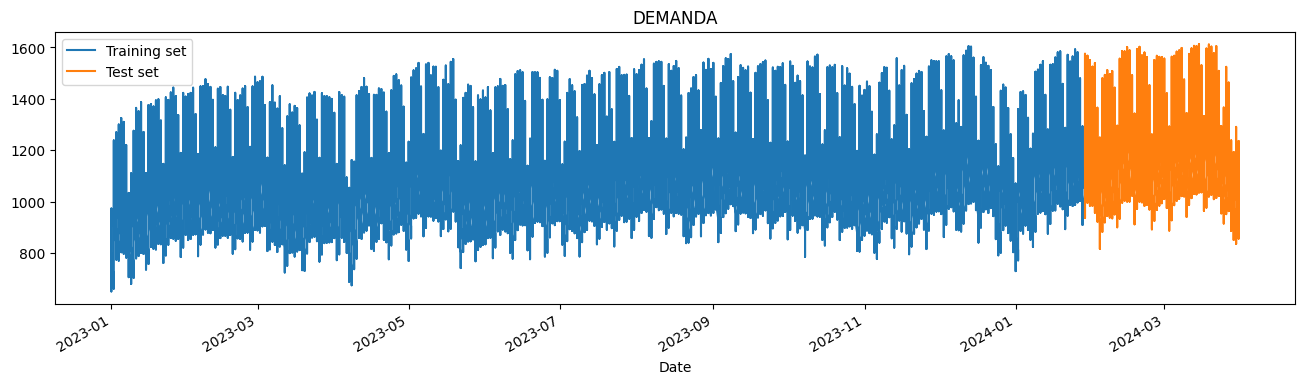

In [ ]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["DEMANDA"]['2023-01-01':fecha_inicio_pred + timedelta(days=-1)].plot(figsize=(16,4),legend=True)
#dataset["DEMANDA"][entrenamiento:validacion].plot(figsize=(16,4),legend=True)
dataset["DEMANDA"][fecha_inicio_pred:fin_pruebas].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set' ])
plt.title('DEMANDA')
plt.show()

In [ ]:
dataset[fecha_inicio_pred.strftime("%Y-%m-%d"):fin_pruebas]

,TIPO DIA,AÑO,MES,DIA,HORA,DEMANDA,Demanda_anterior,Total Residencial,Total No Residencial,Industrial,...,T_DIA_PRED_2--ENE,T_DIA_PRED_25-1,T_DIA_PRED_DOM,T_DIA_PRED_L-DE,T_DIA_PRED_LFEST,T_DIA_PRED_LUN-MADLF,T_DIA_PRED_MAR-VIE,T_DIA_PRED_MV-DE,T_DIA_PRED_OFEST,T_DIA_PRED_SAB
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-29,LUNES,2024,1,29,0,994.04434,1055.43577,2380986.0,220018.0,25180.0,...,0,0,0,0,0,1,0,0,0,0
2024-01-29,LUNES,2024,1,29,1,958.32255,994.04434,2380986.0,220018.0,25180.0,...,0,0,0,0,0,1,0,0,0,0
2024-01-29,LUNES,2024,1,29,2,939.22434,958.32255,2380986.0,220018.0,25180.0,...,0,0,0,0,0,1,0,0,0,0
2024-01-29,LUNES,2024,1,29,3,937.92741,939.22434,2380986.0,220018.0,25180.0,...,0,0,0,0,0,1,0,0,0,0
2024-01-29,LUNES,2024,1,29,4,996.99799,937.92741,2380986.0,220018.0,25180.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,DSS,2024,3,31,19,1236.59484,1211.76245,2390634.0,221389.0,25767.0,...,0,0,0,0,0,0,0,0,0,0
2024-03-31,DSS,2024,3,31,20,1194.09246,1236.59484,2390634.0,221389.0,25767.0,...,0,0,0,0,0,0,0,0,0,0
2024-03-31,DSS,2024,3,31,21,1135.40287,1194.09246,2390634.0,221389.0,25767.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dataset.columns

Index(['TIPO DIA', 'AÑO', 'MES', 'DIA', 'HORA', 'DEMANDA', 'Demanda_anterior',
       'Total Residencial', 'Total No Residencial', 'Industrial',
       'total_usuarios', 'ALLSKY_SFC_SW_DWN_pond', 'ALLSKY_KT_pond',
       'T2M_pond', 'RH2M_pond', 'PRECTOTCORR_pond', 'CLRSKY_SFC_SW_DWN_pond',
       'T2MWET_pond', 'Tasa de cambio representativa del mercado (TRM)', 'IPP',
       'IPC', 'ALLSKY_SFC_SW_DWN_AREA METROPOLITANA DEL VALLE DE ABURRÁ',
       'ALLSKY_SFC_SW_DWN_BAJO CAUCA', 'ALLSKY_SFC_SW_DWN_MAGDALENA MEDIO',
       'ALLSKY_SFC_SW_DWN_NORDESTE', 'ALLSKY_SFC_SW_DWN_NORTE',
       'ALLSKY_SFC_SW_DWN_OCCIDENTE', 'ALLSKY_SFC_SW_DWN_ORIENTE',
       'ALLSKY_SFC_SW_DWN_SUROESTE', 'ALLSKY_SFC_SW_DWN_URABA',
       'PRECTOTCORR_AREA METROPOLITANA DEL VALLE DE ABURRÁ',
       'PRECTOTCORR_BAJO CAUCA', 'PRECTOTCORR_MAGDALENA MEDIO',
       'PRECTOTCORR_NORDESTE', 'PRECTOTCORR_NORTE', 'PRECTOTCORR_OCCIDENTE',
       'PRECTOTCORR_ORIENTE', 'PRECTOTCORR_SUROESTE', 'PRECTOTCORR_URABA',
      

In [ ]:
#numeric_columns = ['DEMANDA','Demanda_anterior','Delta_24h', 'Delta_25h','HORA','Total Residencial', 'Industrial',
                   #'T2M_AREA METROPOLITANA DEL VALLE DE ABURRÁ','T2M_URABA','T_DIA_2--ENE', 'T_DIA_25-1', 'T_DIA_DOM', 'T_DIA_L-DE',
                   #'T_DIA_LFEST', 'T_DIA_LUN-MADLF', 'T_DIA_MAR-VIE', 'T_DIA_MV-DE','T_DIA_OFEST', 'T_DIA_SAB']

#dataset=dataset[numeric_columns]

# Normalizar los datos usando MinMaxScaler
#sc = MinMaxScaler(feature_range=(0,1))

#dataset = pd.DataFrame(sc.fit_transform(dataset), columns=dataset.columns, index=dataset.index)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28392 entries, 2021-01-04 to 2024-03-31
Data columns (total 83 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   TIPO DIA                                                  28392 non-null  object 
 1   AÑO                                                       28392 non-null  int64  
 2   MES                                                       28392 non-null  int64  
 3   DIA                                                       28392 non-null  int64  
 4   HORA                                                      28392 non-null  int64  
 5   DEMANDA                                                   28392 non-null  float64
 6   Demanda_anterior                                          28392 non-null  float64
 7   Total Residencial                                         28392 non-null  float64
 8  

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from itertools import product



resultados=pd.DataFrame()

columnas = ['Delta_24h', 'Delta_25h','HORA','Total Residencial', 'Industrial',
            'T2M_AREA METROPOLITANA DEL VALLE DE ABURRÁ','T2M_URABA','T_DIA_2--ENE', 'T_DIA_25-1', 'T_DIA_DOM', 'T_DIA_L-DE',
                   'T_DIA_LFEST', 'T_DIA_LUN-MADLF', 'T_DIA_MAR-VIE', 'T_DIA_MV-DE','T_DIA_OFEST', 'T_DIA_SAB']

for semana in range(semanas_test):
  print("pronosticando entre las fechas ",fecha_inicio_pred," y ", fecha_fin_pred)

  # Checking for missing values
  #training_set = dataset[:fecha_inicio_pred.strftime("%Y-%m-%d")].iloc[:,5:6].values
  #validation_set = dataset[entrenamiento:validacion].iloc[:,5:6].values
  #test_set = dataset[fecha_inicio_pred.strftime("%Y-%m-%d"):fin_pruebas].iloc[:,5:6].values
  #validation_set[np.isnan(validation_set)] = dataset['DEMANDA'].max()

  training_set = dataset[:fecha_inicio_pred + timedelta(days=-1)]
  test_set = dataset[fecha_inicio_pred.strftime("%Y-%m-%d"):fecha_fin_pred]



  p_values = range(1, 4)
  d_values = range(1, 3)
  q_values = range(1, 4)
  P_values = [1]
  D_values = [1]
  Q_values = [1]
  s_values = [24]

  params = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

  best_score, best_cfg = float("inf"), None

  for param in params:
      p, d, q, P, D, Q, s = param
      model = SARIMAX(endog=training_set['DEMANDA'].values,exog=training_set[columnas].values, order=(p, d, q), seasonal_order=(P, D, Q, s))
      sarimax_fit = model.fit()
      predictiones = sarimax_fit.get_forecast(steps=steps_ahead+blackout,exog=test_set[columnas][:steps_ahead+blackout].values)
      mape = mean_absolute_percentage_error(test_set['DEMANDA'].values, predictiones.predicted_mean)
      print('mape', mape, 'param', param)
      if mape < best_score:
          best_score, best_cfg = mape, param

  print('best_score', best_score, 'best_cfg', best_cfg)

pronosticando entre las fechas  2024-01-29 00:00:00  y  2024-02-11 00:00:00
mape 0.03767234658776025 param (1, 1, 1, 1, 1, 1, 24)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mape 0.03779559391516493 param (1, 1, 2, 1, 1, 1, 24)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mape 0.03772238509334799 param (1, 1, 3, 1, 1, 1, 24)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mape 0.061699823188660505 param (1, 2, 1, 1, 1, 1, 24)
mape 0.0660535566923585 param (1, 2, 2, 1, 1, 1, 24)
mape 0.0648804836088766 param (1, 2, 3, 1, 1, 1, 24)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mape 0.03766167329712321 param (2, 1, 1, 1, 1, 1, 24)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mape 0.06186032646442966 param (2, 1, 2, 1, 1, 1, 24)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mape 0.039694306148956526 param (2, 1, 3, 1, 1, 1, 24)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


mape 0.2813271048333745 param (2, 2, 1, 1, 1, 1, 24)


In [ ]:
predictiones

In [ ]:
valores_predichos = predictiones.predicted_mean

In [ ]:
valores_predichos

array([1003.96902496,  970.06661766,  951.29401152,  947.31158478,
        996.14872636, 1093.3932465 , 1186.22340129, 1278.70477369,
       1359.06440913, 1414.56040139, 1470.56301095, 1520.88629132,
       1530.62749111, 1508.59451009, 1510.47628135, 1515.68722551,
       1487.5945578 , 1428.05397371, 1483.06424598, 1501.90878463,
       1443.84603222, 1343.90266465, 1224.72613232, 1122.11489512,
       1038.69330422,  995.88062898,  971.14835879,  966.51995832,
       1010.56441167, 1104.89185725, 1187.75886885, 1271.27929111,
       1342.71944781, 1387.79637913, 1453.53723932, 1510.13161491,
       1524.93365154, 1506.32062717, 1504.5167555 , 1502.06837736,
       1469.17491723, 1421.28711806, 1478.11481874, 1480.63612201,
       1421.6608556 , 1323.73169478, 1215.22702892, 1117.51293086,
       1033.2024824 ,  993.01507597,  967.78357861,  964.53143082,
       1011.66916548, 1114.68549679, 1204.62575343, 1286.84700054,
       1354.91256298, 1396.94837192, 1458.94670051, 1508.57082

In [ ]:

  # Definir el modelo SARIMAX con las series temporales principales y las variables exógenas
  modelo_sarimax = SARIMAX(endog=training_set['DEMANDA'], exog=training_set[columnas])


  param_grid = {'order': [(1, 1, 1), (2, 1, 0), (0, 1, 1)],
              'seasonal_order': [(1, 1, 1, 12), (0, 1, 1, 12)]}

  tscv = TimeSeriesSplit(n_splits=3)
  grid_search = GridSearchCV(modelo_sarimax, param_grid, scoring='neg_mean_squared_error', cv=tscv)

  # Instanciar el objeto GridSearchCV con el modelo SARIMAX y otros parámetros
  grid_search = GridSearchCV(estimator=modelo_sarimax, param_grid=param_grid, scoring=sarimax_exog_cv_score, cv=None)

  # Ejecutar la búsqueda en cuadrícula
  grid_search.fit(X=training_set[columnas].values, y=training_set['DEMANDA'].values)

  # Mostrar los mejores hiperparámetros encontrados
  print("Mejores hiperparámetros:", grid_search.best_params_)

  # Obtener el mejor modelo
  mejor_modelo = grid_search.best_estimator_

  # Ajustar el mejor modelo a los datos completos
  mejor_modelo.fit(X=training_set[columnas].values, y=training_set['DEMANDA'].values)



  # Realiza la predicción
  prediccion = mejor_modelo.get_forecast(steps=steps_ahead+blackout,exog=test_set[columnas][:steps_ahead+blackout].values)

  # Obtén los valores predichos
  valores_predichos = prediccion.predicted_mean

  # Obtén los intervalos de confianza de las predicciones
  intervalo_confianza = prediccion.conf_int()

  fecha_inicio_pred, fecha_fin_pred=fecha_inicio_pred + timedelta(days=dias_to_pred//2), fecha_fin_pred + timedelta(days=dias_to_pred//2)

  resultados= pd.concat([resultados, pd.DataFrame(valores_predichos[-168:])], ignore_index=True)

In [ ]:
res, rmse=metricas(dataset['DEMANDA'][entrenamiento:fin_pruebas].values,resultados.values)

In [ ]:
graficar_pred(res)

In [ ]:
resultados=pd.DataFrame()

columnas = ['Delta_24h', 'Delta_25h','HORA','Total Residencial', 'Industrial',
            'T2M_AREA METROPOLITANA DEL VALLE DE ABURRÁ','T2M_URABA','T_DIA_2--ENE', 'T_DIA_25-1', 'T_DIA_DOM', 'T_DIA_L-DE',
                   'T_DIA_LFEST', 'T_DIA_LUN-MADLF', 'T_DIA_MAR-VIE', 'T_DIA_MV-DE','T_DIA_OFEST', 'T_DIA_SAB']



# Checking for missing values
#training_set = dataset[:fecha_inicio_pred.strftime("%Y-%m-%d")].iloc[:,5:6].values
#validation_set = dataset[entrenamiento:validacion].iloc[:,5:6].values
#test_set = dataset[fecha_inicio_pred.strftime("%Y-%m-%d"):fin_pruebas].iloc[:,5:6].values
#validation_set[np.isnan(validation_set)] = dataset['DEMANDA'].max()

training_set = dataset[:fecha_inicio_pred + timedelta(days=-1)]
test_set = dataset[fecha_inicio_pred.strftime("%Y-%m-%d"):fecha_fin_pred]

modelo = SARIMAX(endog=training_set['DEMANDA'].values,exog=training_set[columnas].values, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))

# Ajustar el modelo a los datos
sarimax_fit = modelo.fit()



# Realiza la predicción
prediccion = sarimax_fit.get_forecast(steps=steps_ahead+blackout,exog=test_set[columnas][:steps_ahead+blackout].values)

# Obtén los valores predichos
valores_predichos = prediccion.predicted_mean

# Obtén los intervalos de confianza de las predicciones
intervalo_confianza = prediccion.conf_int()

fecha_inicio_pred, fecha_fin_pred=fecha_inicio_pred + timedelta(days=dias_to_pred//2), fecha_fin_pred + timedelta(days=dias_to_pred//2)

resultados= pd.concat([resultados, pd.DataFrame(valores_predichos[-168:])], ignore_index=True)


# Definir los hiperparámetros a ajustar
param_grid = {
    'order': [(p, d, q) for p in range(3) for d in range(2) for q in range(3)],
    'seasonal_order': [((P, D, Q), s) for P in range(2) for D in range(2) for Q in range(2) for s in [12]]
}

# Definir el modelo SARIMAX
modelo = SARIMAX()

# Definir el objeto GridSearchCV
grid_search = GridSearchCV(modelo, param_grid, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))

# Ejecutar la búsqueda en cuadrícula
grid_search.fit(datos)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo
mejor_modelo = grid_search.best_estimator_

# Ajustar el mejor modelo a los datos completos
mejor_modelo.fit(datos)